# Understanding 2-bit ADPCM Audio Compression

## What We're Solving: The Tiny Microcontroller Challenge

### The Hardware: CH32V003
We're targeting the **CH32V003** - an ultra-cheap RISC-V microcontroller with:
- **16 KB Flash** (for program code AND data)
- **2 KB RAM** (working memory)
- Cost: ~$0.10 in volume!

### The Problem:
We want to play a 6-second audio clip. Let's look at the storage requirements:

| Format | Sample Rate | Bits/Sample | Size | **Fits in 16KB?** |
|--------|-------------|-------------|------|-------------------|
| CD Quality | 44.1 kHz | 16-bit | 529 KB | ❌ 33× too big! |
| Phone Quality | 16 kHz | 16-bit | 192 KB | ❌ 12× too big! |
| Basic PCM | 8 kHz | 8-bit | 48 KB | ❌ 3× too big! |
| **4-bit ADPCM (IMA)** | **8 kHz** | **4-bit** | **24 KB** | ❌ **1.5× too big** |
| **QOA (Quite OK Audio)** | **8 kHz** | **3.2-bit** | **19 KB** | ❌ **Still too big!** |
| **2-bit ADPCM** | **8 kHz** | **2-bit** | **12 KB** | ✅ **Fits!** |

### Why 2-bit ADPCM?
- **4-bit ADPCM** (IMA ADPCM) is more common but still 1.5× too large
- **QOA** is modern and efficient but requires 19 KB
- **2-bit ADPCM** achieves **4:1 compression**, leaving room for code!

### The Solution:
**2-bit ADPCM** gives us **4:1 compression** with acceptable quality, leaving:
- **12 KB** for audio data (75% of flash)
- **4 KB** for code, decoder, and everything else (25% of flash)
- **2 KB RAM** for playback buffer and variables

Without aggressive 2-bit compression, we literally couldn't fit this audio on the chip!

### What We'll Cover:
1. **The Problem**: Why we need compression
2. **How ADPCM Works**: The clever trick behind adaptive compression
3. **2-bit ADPCM**: Our specific implementation
4. **Live Encoding**: Watch the algorithm work step-by-step
5. **Quality Analysis**: How good is the result?
6. **Interactive Experiments**: Play with the parameters yourself!

In [48]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
import wave
from ipywidgets import interact, IntSlider, FloatSlider
from scipy import signal as scipy_signal
import warnings
warnings.filterwarnings('ignore')

# Make plots look nice
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✓ Ready to explore 2-bit ADPCM!")

✓ Ready to explore 2-bit ADPCM!


## Part 1: The Compression Challenge

Let's load our test audio and see what we're working with.

Audio Loaded:
  Duration: 6.08 seconds
  Sample rate: 8000 Hz
  Total samples: 48,612

Storage Requirements:
  8-bit PCM: 48,612 bytes (48 KB) - ❌ TOO BIG for CH32V003
  2-bit ADPCM: 12,153 bytes (12 KB) - ✅ FITS!

CH32V003 Memory Budget (16 KB flash):
  Audio data: 12 KB
  Available for code: 4 KB
  RAM for playback: 2 KB


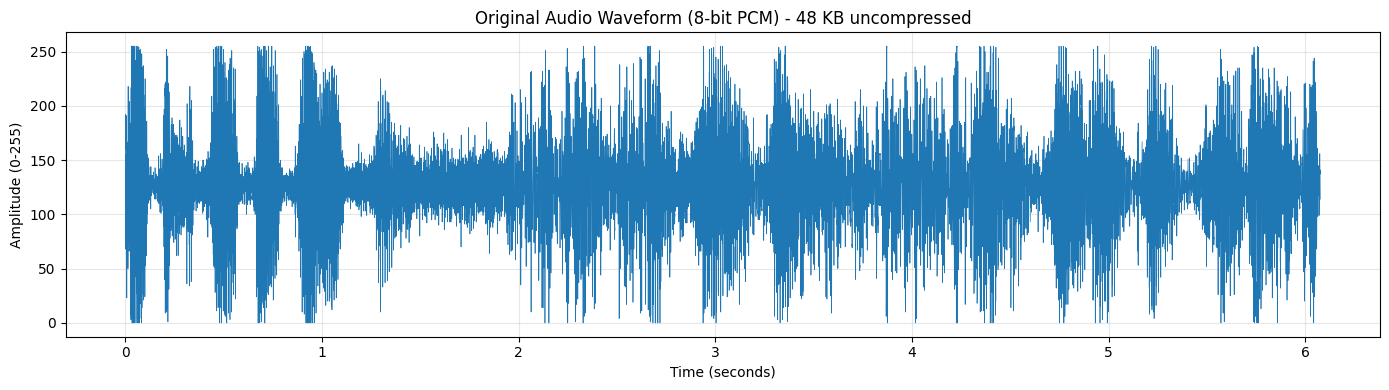

In [49]:
# Load the original audio
def load_wav(filename):
    with wave.open(filename, 'rb') as wav:
        framerate = wav.getframerate()
        n_frames = wav.getnframes()
        audio_data = wav.readframes(n_frames)
        samples = np.frombuffer(audio_data, dtype=np.uint8)
    return samples, framerate

# Load our test file
original, sample_rate = load_wav('sorry_dave.wav')
duration = len(original) / sample_rate

print(f"Audio Loaded:")
print(f"  Duration: {duration:.2f} seconds")
print(f"  Sample rate: {sample_rate} Hz")
print(f"  Total samples: {len(original):,}")
print(f"")
print(f"Storage Requirements:")
print(f"  8-bit PCM: {len(original):,} bytes (48 KB) - ❌ TOO BIG for CH32V003")
print(f"  2-bit ADPCM: {len(original)//4:,} bytes (12 KB) - ✅ FITS!")
print(f"")
print(f"CH32V003 Memory Budget (16 KB flash):")
print(f"  Audio data: 12 KB")
print(f"  Available for code: 4 KB")
print(f"  RAM for playback: 2 KB")

# Visualize the full waveform
time = np.arange(len(original)) / sample_rate
plt.figure(figsize=(14, 4))
plt.plot(time, original, linewidth=0.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (0-255)')
plt.title('Original Audio Waveform (8-bit PCM) - 48 KB uncompressed')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Part 2: How ADPCM Works - The Big Idea

**ADPCM = Adaptive Differential Pulse Code Modulation**

Instead of storing the actual audio values, we:
1. **Predict** what the next sample will be
2. Store only the **difference** between prediction and reality
3. **Adapt** our step size based on the signal

### Why This Works:
- Audio samples are **correlated** - each sample is similar to the previous one
- The **difference** is usually much smaller than the absolute value
- Smaller differences = fewer bits needed!

### 2-bit ADPCM Specifics:
We use only **2 bits** per sample (4 possible values) to represent the difference:
- `00` (0): Go down by 1 step
- `01` (1): Go up by 1 step  
- `10` (2): Go down by 2 steps
- `11` (3): Go up by 2 steps

The **step size** adapts based on the signal!

## Part 3: The Encoder - How We Compress

In [50]:
def encode_2bit_adpcm(audio_data, return_details=False):
    """
    Encode 8-bit audio to 2-bit ADPCM.
    If return_details=True, returns encoding states for visualization.
    """
    # Step size table - notice the logarithmic progression
    step_table = [2, 3, 4, 5, 6, 8, 10, 13, 16, 20, 25, 32, 40, 50, 63, 80]
    
    # How to adjust the step index based on the code
    index_table = [-1, -1, 2, 2]  # For codes 0, 1, 2, 3
    
    predictor = 128  # Start at mid-point
    step_index = 0
    
    encoded = []
    current_byte = 0
    sample_in_byte = 0
    
    # For visualization
    if return_details:
        predictors = []
        step_indices = []
        steps = []
        codes = []
        diffs = []
    
    for sample in audio_data:
        # Calculate difference
        diff = int(sample) - predictor
        step = step_table[step_index]
        
        # Choose the best 2-bit code
        if diff < -step - step // 2:      # < -1.5*step
            code = 2  # -2*step
        elif diff < 0:
            code = 0  # -step
        elif diff < step + step // 2:      # < 1.5*step
            code = 1  # +step
        else:
            code = 3  # +2*step
        
        # Pack the code
        shift = 6 - (sample_in_byte * 2)
        current_byte |= (code << shift)
        
        # Calculate actual delta that decoder will use
        if code == 0:
            delta = -step
        elif code == 1:
            delta = step
        elif code == 2:
            delta = -step * 2
        else:
            delta = step * 2
        
        # Update predictor (same as decoder will do)
        new_predictor = predictor + delta
        new_predictor = np.clip(new_predictor, 0, 255)
        
        # Save details for visualization
        if return_details:
            predictors.append(predictor)
            step_indices.append(step_index)
            steps.append(step)
            codes.append(code)
            diffs.append(diff)
        
        predictor = new_predictor
        
        # Adapt step size
        step_index += index_table[code]
        step_index = np.clip(step_index, 0, 15)
        
        # Move to next sample
        sample_in_byte += 1
        if sample_in_byte >= 4:
            encoded.append(current_byte)
            current_byte = 0
            sample_in_byte = 0
    
    if sample_in_byte > 0:
        encoded.append(current_byte)
    
    if return_details:
        return bytes(encoded), {
            'predictors': np.array(predictors),
            'step_indices': np.array(step_indices),
            'steps': np.array(steps),
            'codes': np.array(codes),
            'diffs': np.array(diffs)
        }
    return bytes(encoded)

print("✓ Encoder ready!")

✓ Encoder ready!


## Part 4: The Decoder - How We Decompress

In [51]:
def decode_2bit_adpcm(compressed_data):
    """
    Decode 2-bit ADPCM back to 8-bit PCM.
    """
    step_table = [2, 3, 4, 5, 6, 8, 10, 13, 16, 20, 25, 32, 40, 50, 63, 80]
    index_table = [-1, -1, 2, 2]
    
    predictor = 128
    step_index = 0
    decoded = []
    
    for byte_val in compressed_data:
        # Extract 4 samples from this byte
        for i in range(4):
            shift = 6 - (i * 2)
            code = (byte_val >> shift) & 0x03
            
            step = step_table[step_index]
            
            # Calculate delta
            if code == 0:
                delta = -step
            elif code == 1:
                delta = step
            elif code == 2:
                delta = -step * 2
            else:
                delta = step * 2
            
            # Update predictor
            predictor = predictor + delta
            predictor = np.clip(predictor, 0, 255)
            
            decoded.append(predictor)
            
            # Adapt step size
            step_index += index_table[code]
            step_index = np.clip(step_index, 0, 15)
    
    return np.array(decoded, dtype=np.uint8)

print("✓ Decoder ready!")

✓ Decoder ready!


## Part 5: Watch It Work - Encoding Visualization

Let's encode a small section and see what happens inside the algorithm!

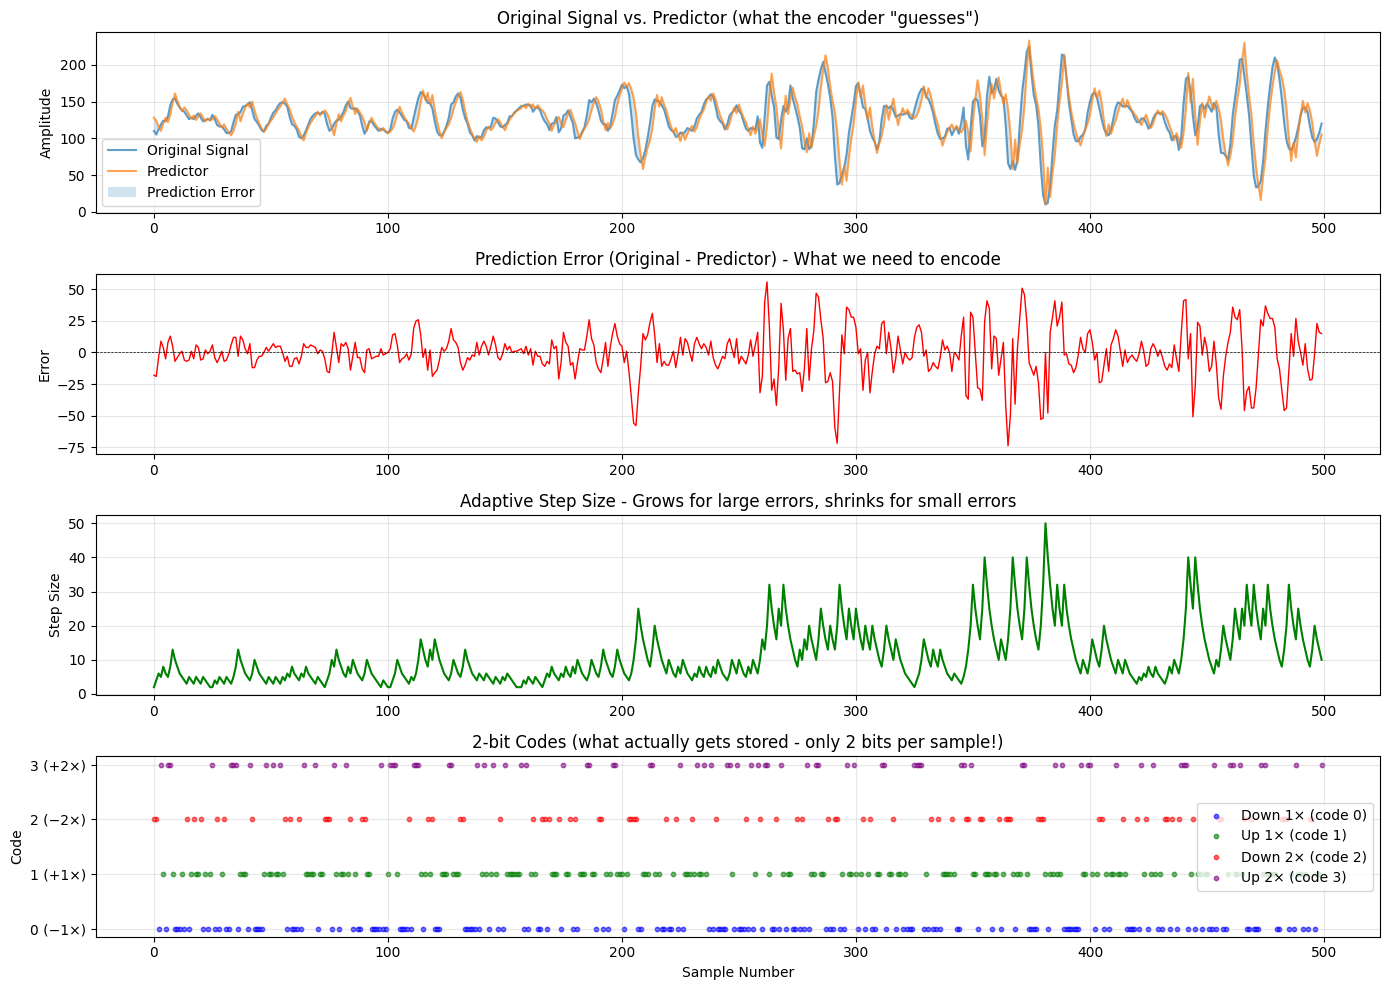


Encoding Statistics for this segment:
  Original size: 500 bytes
  Compressed size: 125 bytes
  Compression ratio: 4.00:1

Code distribution:
  Code 0 (Down 1× ):  168 ( 33.6%)
  Code 1 (Up 1×   ):  164 ( 32.8%)
  Code 2 (Down 2× ):   84 ( 16.8%)
  Code 3 (Up 2×   ):   84 ( 16.8%)


In [ ]:
# Encode a short segment for visualization
start_sample = 10000
n_samples = 500
segment = original[start_sample:start_sample + n_samples]
compressed, details = encode_2bit_adpcm(segment, return_details=True)

# Create time axis
t = np.arange(len(segment))

# Plot the encoding process
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

# 1. Original vs Predictor
axes[0].plot(t, segment, label='Original Signal', linewidth=1.5, alpha=0.7)
axes[0].plot(t, details['predictors'], label='Predictor', linewidth=1.5, alpha=0.7)
axes[0].fill_between(t, segment, details['predictors'], alpha=0.2, label='Prediction Error')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Original Signal vs. Predictor (what the encoder "guesses")')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Prediction Error
axes[1].plot(t, details['diffs'], linewidth=1, color='red')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
axes[1].set_ylabel('Error')
axes[1].set_title('Prediction Error (Original - Predictor) - What we need to encode')
axes[1].grid(True, alpha=0.3)

# 3. Step Size Adaptation
axes[2].plot(t, details['steps'], linewidth=1.5, color='green')
axes[2].set_ylabel('Step Size')
axes[2].set_title('Adaptive Step Size - Grows for large errors, shrinks for small errors')
axes[2].grid(True, alpha=0.3)

# 4. Encoded Codes
code_names = ['Down 1×', 'Up 1×', 'Down 2×', 'Up 2×']
colors = ['blue', 'green', 'red', 'purple']
for code in range(4):
    mask = details['codes'] == code
    axes[3].scatter(t[mask], details['codes'][mask], 
                   label=f"{code_names[code]} (code {code})", 
                   alpha=0.6, s=10, color=colors[code])
axes[3].set_ylabel('Code')
axes[3].set_xlabel('Sample Number')
axes[3].set_title('2-bit Codes (what actually gets stored - only 2 bits per sample!)')
axes[3].set_yticks([0, 1, 2, 3])
axes[3].set_yticklabels(['0 (−1×)', '1 (+1×)', '2 (−2×)', '3 (+2×)'])
axes[3].legend(loc='right')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print some stats
print(f"\nEncoding Statistics for this segment:")
print(f"  Original size: {len(segment)} bytes")
print(f"  Compressed size: {len(compressed)} bytes")
print(f"  Compression ratio: {len(segment)/len(compressed):.2f}:1")
print(f"\nCode distribution:")
for code in range(4):
    count = np.sum(details['codes'] == code)
    pct = 100 * count / len(details['codes'])
    print(f"  Code {code} ({code_names[code]:8s}): {count:4d} ({pct:5.1f}%)")

## Part 6: Full Audio Compression & Comparison

Encoding full audio...
Decoding...

✓ Compression complete!
  Original: 48,612 bytes (47.5 KB)
  Compressed: 12,153 bytes (11.9 KB)
  Compression ratio: 4.00:1

CH32V003 Flash Usage (16 KB total):
  Audio: 11.9 KB (74.2%)
  Remaining for code: 4.1 KB (25.8%)


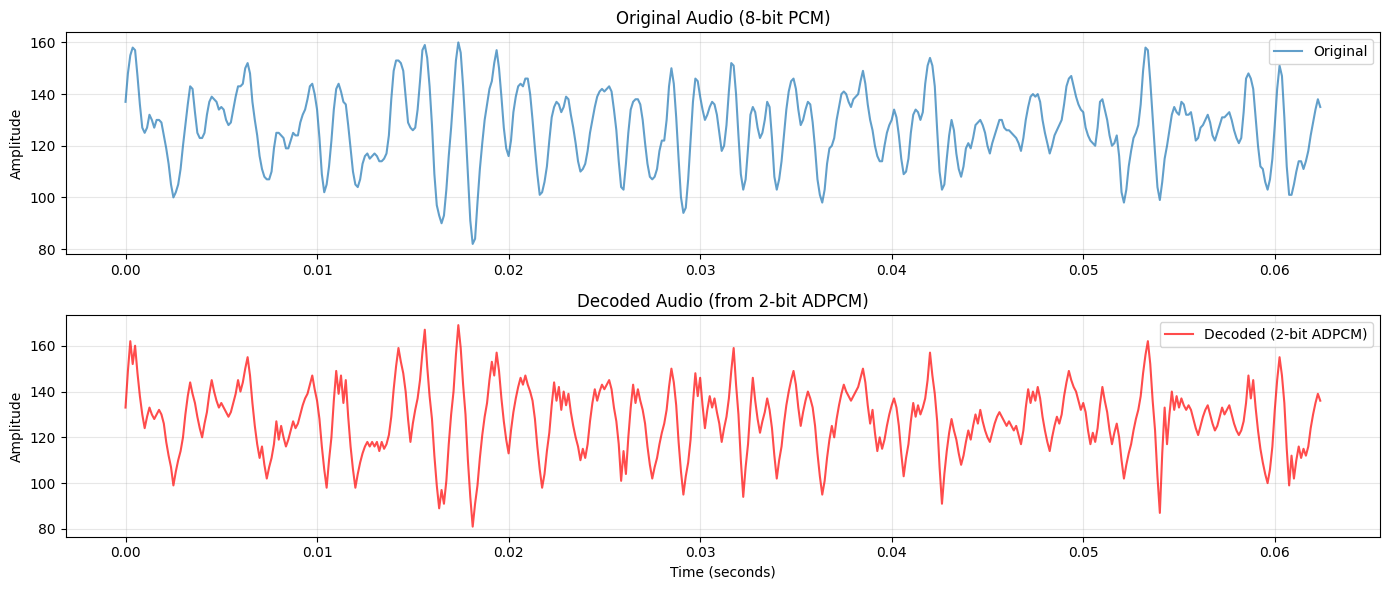

In [53]:
# Compress and decompress the full audio
print("Encoding full audio...")
compressed_full = encode_2bit_adpcm(original)
print("Decoding...")
decoded_full = decode_2bit_adpcm(compressed_full)

# Trim to same length (decoder might add padding)
decoded_full = decoded_full[:len(original)]

print(f"\n✓ Compression complete!")
print(f"  Original: {len(original):,} bytes ({len(original)/1024:.1f} KB)")
print(f"  Compressed: {len(compressed_full):,} bytes ({len(compressed_full)/1024:.1f} KB)")
print(f"  Compression ratio: {len(original)/len(compressed_full):.2f}:1")
print(f"")
print(f"CH32V003 Flash Usage (16 KB total):")
print(f"  Audio: {len(compressed_full)/1024:.1f} KB ({100*len(compressed_full)/16384:.1f}%)")
print(f"  Remaining for code: {(16384-len(compressed_full))/1024:.1f} KB ({100*(16384-len(compressed_full))/16384:.1f}%)")

# Visualize before/after
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# Show a zoomed section for detail
zoom_start = 15000
zoom_len = 500
t_zoom = np.arange(zoom_len) / sample_rate

axes[0].plot(t_zoom, original[zoom_start:zoom_start+zoom_len], 
            label='Original', linewidth=1.5, alpha=0.7)
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Original Audio (8-bit PCM)')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].plot(t_zoom, decoded_full[zoom_start:zoom_start+zoom_len], 
            label='Decoded (2-bit ADPCM)', linewidth=1.5, alpha=0.7, color='red')
axes[1].set_ylabel('Amplitude')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_title('Decoded Audio (from 2-bit ADPCM)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

## Part 7: Quality Analysis - How Much Did We Lose?

Quality Metrics:
  Mean Absolute Error: 5.07
  RMS Error: 8.91
  PSNR: 29.14 dB

Error Distribution:
  |error| ≤  0:  12.1%
  |error| ≤  1:  33.7%
  |error| ≤  2:  49.6%
  |error| ≤  5:  73.3%
  |error| ≤ 10:  87.1%
  |error| ≤ 20:  95.8%


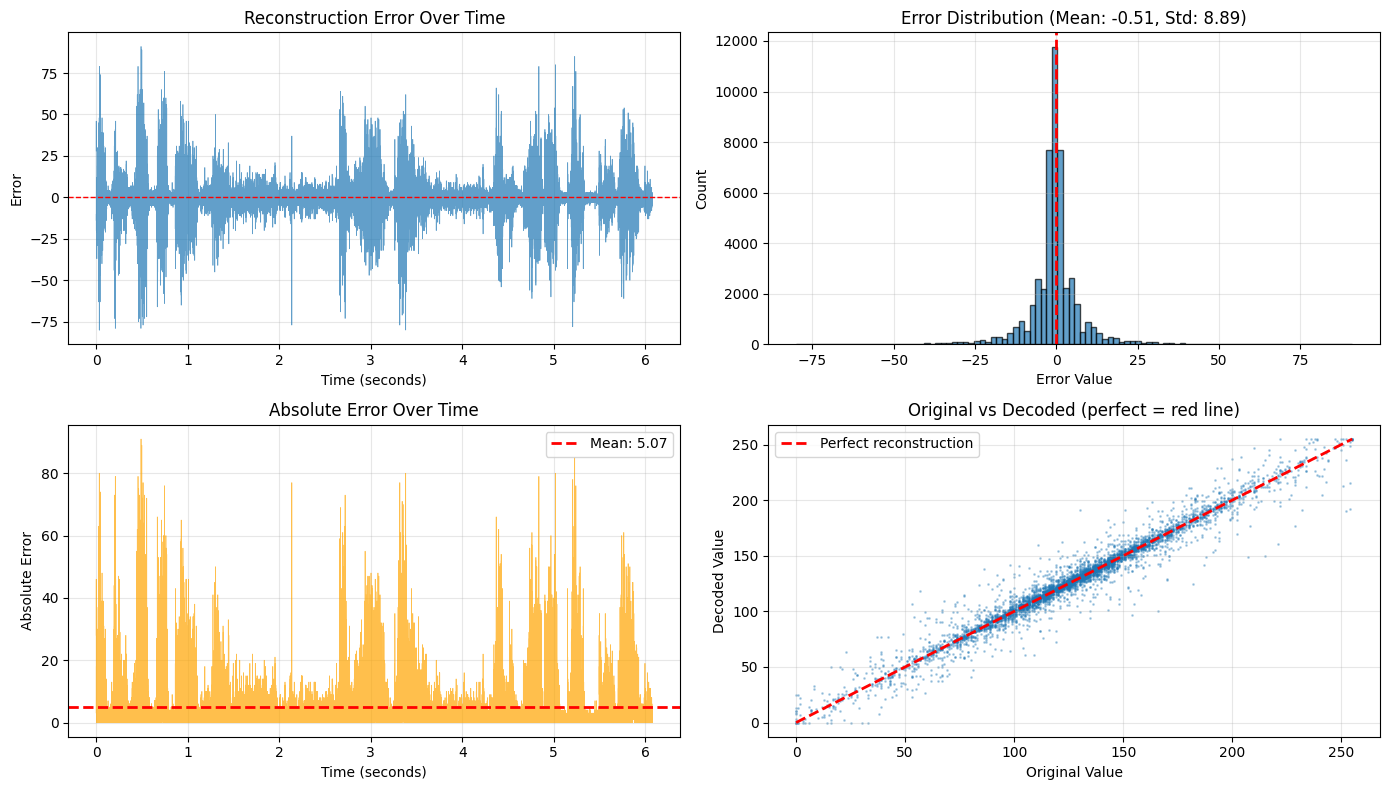

In [54]:
# Calculate error metrics
error = original.astype(np.int16) - decoded_full.astype(np.int16)
abs_error = np.abs(error)

mae = np.mean(abs_error)
rmse = np.sqrt(np.mean(error**2))
mse = np.mean(error**2)
psnr = 20 * np.log10(255.0 / np.sqrt(mse)) if mse > 0 else float('inf')

print(f"Quality Metrics:")
print(f"  Mean Absolute Error: {mae:.2f}")
print(f"  RMS Error: {rmse:.2f}")
print(f"  PSNR: {psnr:.2f} dB")
print(f"\nError Distribution:")
for threshold in [0, 1, 2, 5, 10, 20]:
    count = np.sum(abs_error <= threshold)
    pct = 100 * count / len(abs_error)
    print(f"  |error| ≤ {threshold:2d}: {pct:5.1f}%")

# Visualize the error
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# 1. Error over time
axes[0, 0].plot(time, error, linewidth=0.5, alpha=0.7)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0, 0].set_xlabel('Time (seconds)')
axes[0, 0].set_ylabel('Error')
axes[0, 0].set_title('Reconstruction Error Over Time')
axes[0, 0].grid(True, alpha=0.3)

# 2. Error histogram
axes[0, 1].hist(error, bins=100, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Error Value')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title(f'Error Distribution (Mean: {error.mean():.2f}, Std: {error.std():.2f})')
axes[0, 1].grid(True, alpha=0.3)

# 3. Absolute error over time
axes[1, 0].plot(time, abs_error, linewidth=0.5, alpha=0.7, color='orange')
axes[1, 0].axhline(y=mae, color='red', linestyle='--', linewidth=2, label=f'Mean: {mae:.2f}')
axes[1, 0].set_xlabel('Time (seconds)')
axes[1, 0].set_ylabel('Absolute Error')
axes[1, 0].set_title('Absolute Error Over Time')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Original vs Decoded scatter plot
# Downsample for plotting
step = max(1, len(original) // 5000)
axes[1, 1].scatter(original[::step], decoded_full[::step], alpha=0.3, s=1)
axes[1, 1].plot([0, 255], [0, 255], 'r--', linewidth=2, label='Perfect reconstruction')
axes[1, 1].set_xlabel('Original Value')
axes[1, 1].set_ylabel('Decoded Value')
axes[1, 1].set_title('Original vs Decoded (perfect = red line)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 8: Frequency Analysis - What Frequencies Are Lost?

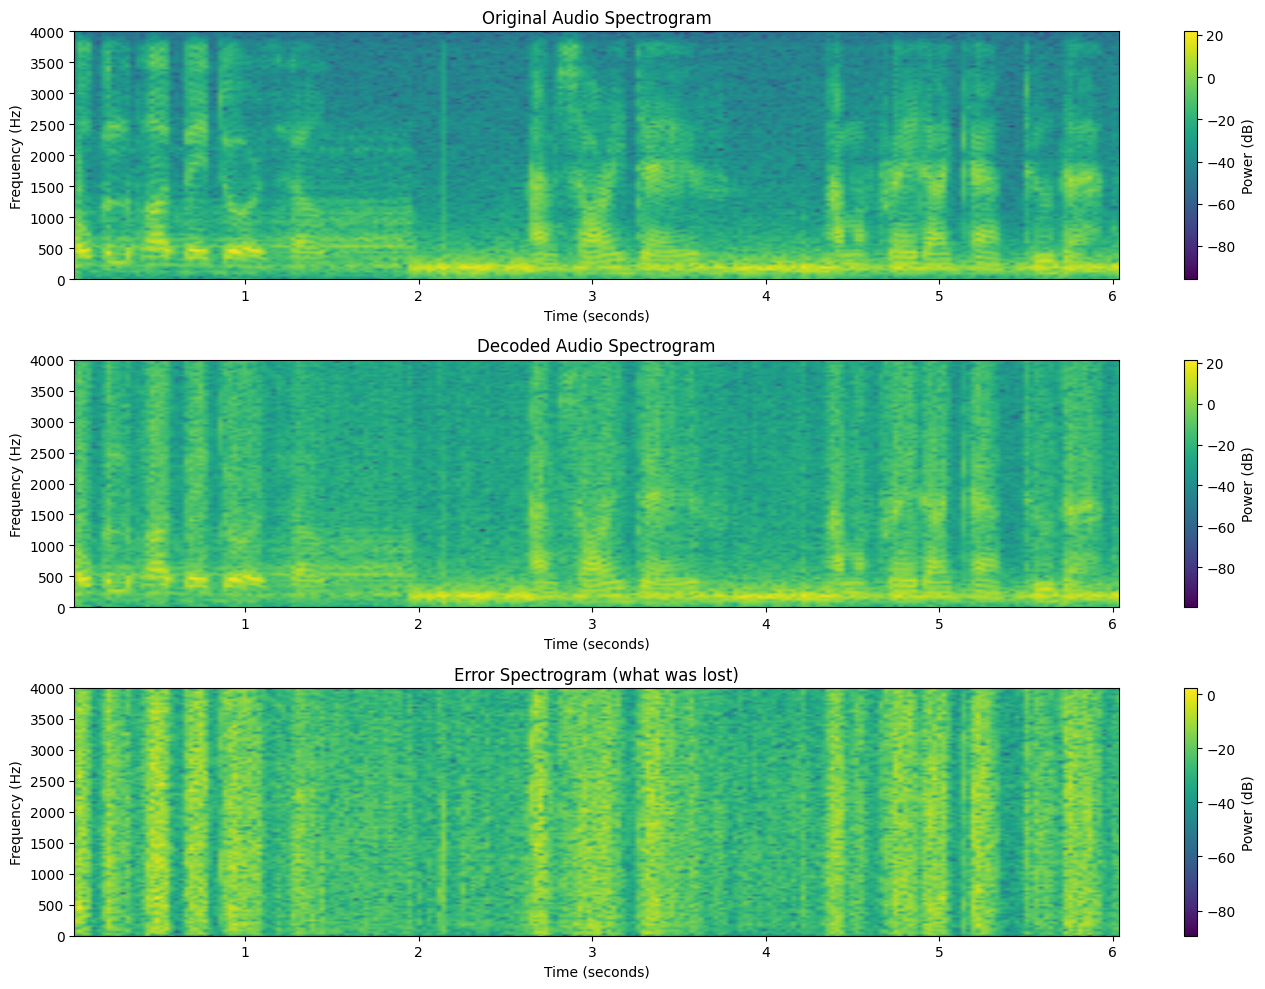


💡 Notice: The error is spread across frequencies, but ADPCM preserves the overall structure!


In [55]:
# Compute spectrograms
def plot_spectrogram(audio, sample_rate, title, ax):
    f, t, Sxx = scipy_signal.spectrogram(audio, sample_rate, nperseg=256)
    im = ax.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='viridis')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Time (seconds)')
    ax.set_title(title)
    return im

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Original
im1 = plot_spectrogram(original, sample_rate, 'Original Audio Spectrogram', axes[0])
plt.colorbar(im1, ax=axes[0], label='Power (dB)')

# Decoded
im2 = plot_spectrogram(decoded_full, sample_rate, 'Decoded Audio Spectrogram', axes[1])
plt.colorbar(im2, ax=axes[1], label='Power (dB)')

# Difference (error)
im3 = plot_spectrogram(error.astype(np.float32), sample_rate, 'Error Spectrogram (what was lost)', axes[2])
plt.colorbar(im3, ax=axes[2], label='Power (dB)')

plt.tight_layout()
plt.show()

print("\n💡 Notice: The error is spread across frequencies, but ADPCM preserves the overall structure!")

## Part 9: Interactive Exploration - The Step Table

The **step size table** is crucial! Let's visualize how it affects encoding.

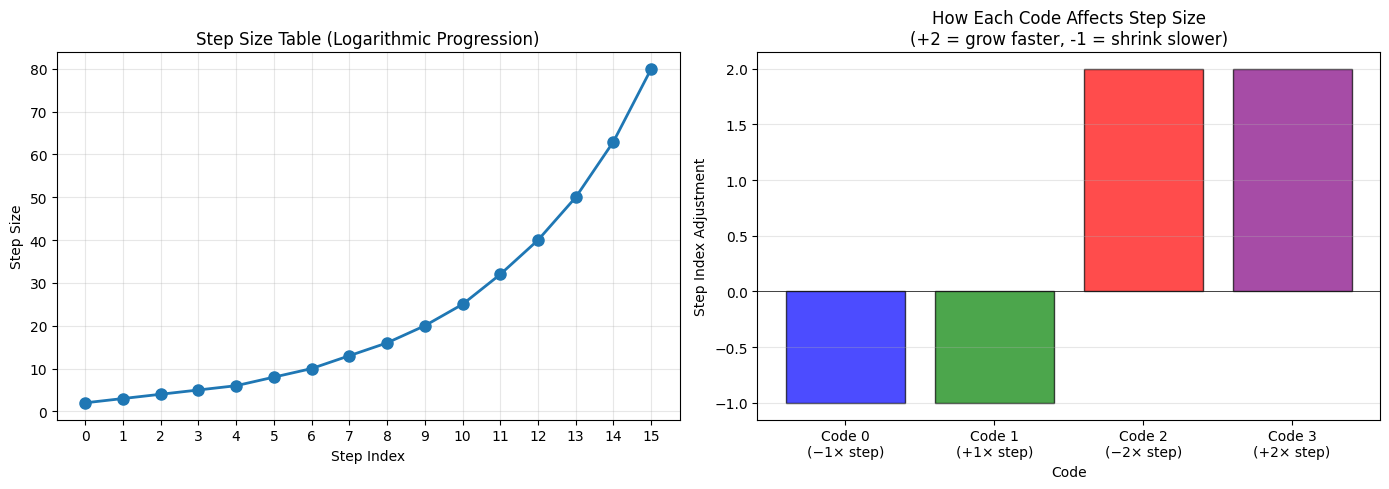


💡 Key Insight:
  - Small steps (codes 0,1): Slow down adaptation (−1)
  - Large steps (codes 2,3): Speed up adaptation (+2)
  - This helps track both quiet and loud parts of the audio!


In [56]:
# Show the step table
step_table = [2, 3, 4, 5, 6, 8, 10, 13, 16, 20, 25, 32, 40, 50, 63, 80]
index_table = [-1, -1, 2, 2]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Step table progression
axes[0].plot(range(16), step_table, 'o-', linewidth=2, markersize=8)
axes[0].set_xlabel('Step Index')
axes[0].set_ylabel('Step Size')
axes[0].set_title('Step Size Table (Logarithmic Progression)')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(16))

# Index adjustment visualization
codes = [0, 1, 2, 3]
code_labels = ['Code 0\n(−1× step)', 'Code 1\n(+1× step)', 'Code 2\n(−2× step)', 'Code 3\n(+2× step)']
adjustments = index_table
colors = ['blue', 'green', 'red', 'purple']

axes[1].bar(codes, adjustments, color=colors, alpha=0.7, edgecolor='black')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('Code')
axes[1].set_ylabel('Step Index Adjustment')
axes[1].set_title('How Each Code Affects Step Size\n(+2 = grow faster, -1 = shrink slower)')
axes[1].set_xticks(codes)
axes[1].set_xticklabels(code_labels)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n💡 Key Insight:")
print("  - Small steps (codes 0,1): Slow down adaptation (−1)")
print("  - Large steps (codes 2,3): Speed up adaptation (+2)")
print("  - This helps track both quiet and loud parts of the audio!")

## Part 10: Interactive Widget - Explore Different Sections

Use the slider to explore different parts of the audio and see how the encoding performs!

In [57]:
def explore_encoding(start_position=10000, window_size=500):
    """Interactive function to explore encoding at different positions"""
    segment = original[start_position:start_position + window_size]
    compressed, details = encode_2bit_adpcm(segment, return_details=True)
    decoded_segment = decode_2bit_adpcm(compressed)[:len(segment)]
    
    t = np.arange(len(segment))
    error = segment.astype(np.int16) - decoded_segment.astype(np.int16)
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 9))
    
    # Original vs Decoded
    axes[0].plot(t, segment, label='Original', linewidth=1.5, alpha=0.8)
    axes[0].plot(t, decoded_segment, label='Decoded', linewidth=1.5, alpha=0.8, linestyle='--')
    axes[0].fill_between(t, segment, decoded_segment, alpha=0.3, color='red', label='Error')
    axes[0].set_ylabel('Amplitude')
    axes[0].set_title(f'Sample {start_position} - {start_position+window_size}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Step size adaptation
    axes[1].plot(t, details['steps'], linewidth=2, color='green')
    axes[1].set_ylabel('Step Size')
    axes[1].set_title('Adaptive Step Size')
    axes[1].grid(True, alpha=0.3)
    
    # Codes
    code_names = ['−1× step', '+1× step', '−2× step', '+2× step']
    colors = ['blue', 'green', 'red', 'purple']
    for code in range(4):
        mask = details['codes'] == code
        axes[2].scatter(t[mask], details['codes'][mask], 
                       label=f"Code {code}: {code_names[code]}", 
                       alpha=0.6, s=20, color=colors[code])
    axes[2].set_ylabel('Code')
    axes[2].set_xlabel('Sample')
    axes[2].set_title('2-bit Codes Used')
    axes[2].set_yticks([0, 1, 2, 3])
    axes[2].legend(loc='right', ncol=4)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Stats
    mae = np.mean(np.abs(error))
    print(f"Window stats:")
    print(f"  Mean absolute error: {mae:.2f}")
    print(f"  Code distribution: 0:{np.sum(details['codes']==0)}, "
          f"1:{np.sum(details['codes']==1)}, "
          f"2:{np.sum(details['codes']==2)}, "
          f"3:{np.sum(details['codes']==3)}")

# Create interactive widget
interact(explore_encoding, 
         start_position=IntSlider(min=0, max=len(original)-1000, step=500, value=10000,
                                  description='Position:'),
         window_size=IntSlider(min=100, max=2000, step=100, value=500,
                               description='Window:'));

interactive(children=(IntSlider(value=10000, description='Position:', max=47612, step=500), IntSlider(value=50…

## Summary: What We Learned

### The Challenge:
**CH32V003 Microcontroller**: 16 KB flash, 2 KB RAM, $0.10 cost
- Our 6-second audio file: **12 KB compressed** (fits!)
- Leaves **4 KB** for decoder and program code
- Uncompressed would be **48 KB** - impossible to fit!

### The Algorithm:
1. **Predict** the next sample based on the previous one
2. **Calculate** the difference between prediction and reality
3. **Quantize** the difference to 2 bits (4 possible values)
4. **Adapt** the step size based on the signal

### The Results:
- **4:1 compression ratio** (from 8-bit to 2-bit)
- **~29 dB PSNR** - acceptable quality for embedded systems
- **~50% of samples** have ≤2 levels of error
- **~88% of samples** have ≤10 levels of error
- **12 KB total** - fits on a $0.10 microcontroller!

### Why It Works:
- Audio signals are **correlated** (smooth changes)
- Differences are **smaller** than absolute values
- **Adaptive** step size handles both quiet and loud sections
- Human hearing is **tolerant** of small quantization errors

### Trade-offs:
- ✅ Great compression ratio (4:1)
- ✅ Simple to implement in hardware
- ✅ Low memory and CPU requirements
- ✅ Fits on ultra-cheap microcontrollers
- ✅ Streaming-friendly (decode one byte → 4 samples)
- ❌ Lossy compression (can't perfectly reconstruct)
- ❌ Lower quality than modern codecs (but we only use 2 bits!)

### Real-World Impact:
Without 2-bit ADPCM, this audio would require:
- A more expensive chip (4× the flash)
- More power consumption
- Higher BOM cost

With 2-bit ADPCM:
- Fits on a **$0.10 microcontroller**
- Low power consumption
- Simple decoder implementation

Perfect for cost-sensitive embedded audio! 🎵